# 0. Import packages

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

In [2]:
# %cd "/content/gdrive/MyDrive/LDS0_K273_DamThiMinhPhuong/Project"

In [3]:
# !pip3 install pandas_profiling --upgrade
# !pip install squarify
# !pip install plotly
# !pip install pyyaml==5.4.1
# !pip install import_ipynb

In [414]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import squarify
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [392]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from pyclustertend import hopkins
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

import import_ipynb
import Lib

# Step 1: Business Ojective
- Company X mainly sells products that are gifts for special occasions. Many customers of the company are wholesale customers.
- Company X wants to be able to sell more products as well as introduce products to the right customers, take care and satisfy customers.
- => SOLUTION: Customer Segmentation with RFM analysis 
    + R - Recency : Time since the last order
    + F - Frequency : Frequency of the customer transactions
    + M - Monetary : Total transaction value

# Step 2: Data Understanding

## 2.1 Data Cleaning

In [6]:
df = pd.read_csv('data/OnlineRetail.csv', encoding= 'unicode_escape')

In [7]:
df.shape

(541909, 8)

In [8]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [10]:
# Check & drop duplicated rows
print(df.duplicated().sum())
df = df.drop_duplicates()
df.shape

5268


(536641, 8)

In [11]:
# rows which contain 'C' in InvoiceNo
df[df['InvoiceNo'].str.contains('C', na=False)].head()

InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

          InvoiceDate  UnitPrice  CustomerID         Country  
141  01-12-2010 09:41      27.50     14527.0  United Kingdom  
154  01-12-2010 09:49       4.65     15311.0  United Kingdom  
235  01-12-2010 10:24       1.65     17548.0  United Kingdom  
236  01-12-2010 10:24       0.29     17548.0  United Kingdom  
237  01-12-2010 10:24       0.29     17548.0  United Kingdom

In [12]:
df[df["InvoiceNo"].str.contains("C", na=False)].describe()

Quantity     UnitPrice    CustomerID
count   9251.000000   9251.000000   8872.000000
mean     -29.787050     48.570430  14990.152953
std     1147.997592    667.926393   1708.230387
min   -80995.000000      0.010000  12346.000000
25%       -6.000000      1.450000  13505.000000
50%       -2.000000      2.950000  14868.000000
75%       -1.000000      5.950000  16393.000000
max       -1.000000  38970.000000  18282.000000

Comment: rows where 'InvoiceNo' contains 'C' have 'Quantity' < 0

In [13]:
# rows which contain 'A' in InvoiceNo
df[df['InvoiceNo'].str.contains('A', na=False)]

InvoiceNo StockCode      Description  Quantity       InvoiceDate  \
299982   A563185         B  Adjust bad debt         1  12-08-2011 14:50   
299983   A563186         B  Adjust bad debt         1  12-08-2011 14:51   
299984   A563187         B  Adjust bad debt         1  12-08-2011 14:52   

        UnitPrice  CustomerID         Country  
299982   11062.06         NaN  United Kingdom  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom

Comment:rows where 'InvoiceNo' contains 'A' have CustomerID == NaN

In [14]:
# drop rows where Quantity < 0
print(df[df.Quantity < 0].shape[0])
df = df[df.Quantity >= 0]
df.shape

10587


(526054, 8)

In [15]:
# drop rows where UnitPrice < 0
print(df[df.UnitPrice < 0].shape[0])
df = df[df.UnitPrice >= 0]
df.shape

2


(526052, 8)

In [16]:
# drop rows where CustomerID == null
df = df[df.CustomerID.notnull()]
df.shape

(392732, 8)

In [17]:
df.isnull().any()

InvoiceNo      False
StockCode      False
Description    False
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID     False
Country        False
dtype: bool

Comment: There are no more nulls in the data set



In [18]:
# Convert column 'InvoiceDate' to datetime datatype
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [19]:
# convert InvoiceNo data type to integer
df.InvoiceNo = df.InvoiceNo.astype(int)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392732 non-null  int64         
 1   StockCode    392732 non-null  object        
 2   Description  392732 non-null  object        
 3   Quantity     392732 non-null  int64         
 4   InvoiceDate  392732 non-null  datetime64[ns]
 5   UnitPrice    392732 non-null  float64       
 6   CustomerID   392732 non-null  float64       
 7   Country      392732 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 27.0+ MB


In [21]:
# pp.ProfileReport(df)

In [22]:
df.describe()

InvoiceNo       Quantity      UnitPrice     CustomerID
count  392732.000000  392732.000000  392732.000000  392732.000000
mean   560591.072436      13.153718       3.125596   15287.734822
std     13087.116747     181.588420      22.240725    1713.567773
min    536365.000000       1.000000       0.000000   12346.000000
25%    549234.000000       2.000000       1.250000   13955.000000
50%    561874.000000       6.000000       1.950000   15150.000000
75%    572061.000000      12.000000       3.750000   16791.000000
max    581587.000000   80995.000000    8142.750000   18287.000000

## 2.2 Data Preparation

In [23]:
# Create new column 'Amount'
df['Amount'] = df['Quantity'] * df['UnitPrice']
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365     71053                  WHITE METAL LANTERN         6   
2     536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Amount  
0 2010-01-12 08:26:00       2.55     17850.0  United Kingdom   15.30  
1 2010-01-12 08:26:00       3.39     17850.0  United Kingdom   20.34  
2 2010-01-12 08:26:00       2.75     17850.0  United Kingdom   22.00  
3 2010-01-12 08:26:00       3.39     17850.0  United Kingdom   20.34  
4 2010-01-12 08:26:00       3.39     17850.0  United Kingdom   20.34

In [24]:
# Get max date of dataframe
max_date = df['InvoiceDate'].max().date()

# Calculate R, F, M
Recency = lambda x: (max_date - x.max().date()).days
Frequency = lambda x: x.nunique()
Monetary = lambda x: round(sum(x),2)

df_RFM = df.groupby('CustomerID').agg({'InvoiceDate' : Recency,
                                        'InvoiceNo' : Frequency,
                                        'Amount' : Monetary,
                                        })

In [25]:
df_RFM.head()

InvoiceDate  InvoiceNo    Amount
CustomerID                                  
12346.0             326          1  77183.60
12347.0              40          7   4310.00
12348.0              76          4   1797.24
12349.0              19          1   1757.55
12350.0             311          1    334.40

In [26]:
# Rename column names
df_RFM.columns = ['Recency', 'Frequency', 'Monetary']

# Descending Sorting 
df_RFM = df_RFM.sort_values('Monetary', ascending=False)

In [27]:
df_RFM.head(5)

Recency  Frequency   Monetary
CustomerID                               
14646.0           2         74  280206.02
18102.0          12         60  259657.30
17450.0           3         46  194390.79
16446.0          89          2  168472.50
14911.0           0        201  143711.17

In [28]:
df_RFM.shape

(4339, 3)

In [29]:
df_RFM.describe()

Recency    Frequency       Monetary
count  4339.000000  4339.000000    4339.000000
mean    105.461858     4.271952    2048.215923
std     115.083263     7.705493    8984.248352
min       0.000000     1.000000       0.000000
25%      22.000000     1.000000     306.455000
50%      61.000000     2.000000     668.560000
75%     161.500000     5.000000    1660.315000
max     697.000000   210.000000  280206.020000

## 2.3 EDA on df_RFM data

In [30]:
# Let’s take a closer look at the data we will need to manipulate.
print('Transactions timeframe from {} to {}'.format(df['InvoiceDate'].min(), df['InvoiceDate'].max()))
print('{:,} transactions don\'t have a customer id'.format(df[df.CustomerID.isnull()].shape[0]))

Transactions timeframe from 2010-01-12 08:26:00 to 2011-12-10 17:19:00
0 transactions don't have a customer id


In [31]:
print('Number of Customers:',df.CustomerID.nunique())
print('Number of Countries:',df.Country.nunique())
print('Number of Invoices:',df.InvoiceNo.nunique())

Number of Customers: 4339
Number of Countries: 37
Number of Invoices: 18536


In [32]:
# Calculate Number of Customers, InvoiceNo and Sum of Amount per Country
groubyCountry = df.groupby(['Country']).agg({
                            'CustomerID': 'nunique',
                            'InvoiceNo': 'nunique',
                            'Amount': 'sum'
                            })

In [33]:
# Calculate percentage of customers of each Country
groubyCountry['%CustomerID']= groubyCountry.CustomerID.apply(lambda x: round(x*100/groubyCountry.CustomerID.sum(),2))
groubyCountry.iloc[:,:4].sort_values(['CustomerID'], ascending=False)[:5]

CustomerID  InvoiceNo       Amount  %CustomerID
Country                                                        
United Kingdom        3921      16649  7285024.644        90.20
Germany                 94        457   228678.400         2.16
France                  87        389   208934.310         2.00
Spain                   30         90    61558.560         0.69
Belgium                 25         98    41196.340         0.58

In [34]:
# Calculate percentage of orders of each Country
groubyCountry['%InvoiceNo']= groubyCountry.InvoiceNo.apply(lambda x: round(x*100/groubyCountry.InvoiceNo.sum(),2))
groubyCountry.iloc[:,[0,1,2,4]].sort_values(['InvoiceNo'], ascending=False)[:5]

CustomerID  InvoiceNo       Amount  %InvoiceNo
Country                                                       
United Kingdom        3921      16649  7285024.644       89.82
Germany                 94        457   228678.400        2.47
France                  87        389   208934.310        2.10
EIRE                     3        260   265262.460        1.40
Belgium                 25         98    41196.340        0.53

In [35]:
# Calculate percentage of Amount of each Country
groubyCountry['%Amount']= groubyCountry.Amount.apply(lambda x: round(x*100/groubyCountry.Amount.sum(),2))
groubyCountry.iloc[:,[0,1,2,5]].sort_values(['Amount'], ascending=False)[:5]

CustomerID  InvoiceNo       Amount  %Amount
Country                                                    
United Kingdom        3921      16649  7285024.644    81.97
Netherlands              9         95   285446.340     3.21
EIRE                     3        260   265262.460     2.98
Germany                 94        457   228678.400     2.57
France                  87        389   208934.310     2.35

Comment:
- Trong hơn 4k khách hàng và 18k đơn hàng đó thì 90% là đến từ UK và các khách hàng ở UK cũng mang lại 82% doanh số cho công ty X
- Ngoài ra khoảng 5% của các chỉ số trên đến từ các nước lân cận với UK.
- Đây là một thông tin rất quan trọng để công ty X có thể đưa ra chiến lược phát triển sp, bán hàng, marketing và chăm sóc khách hàng một cách phù hợp và hiệu quả nhất. 

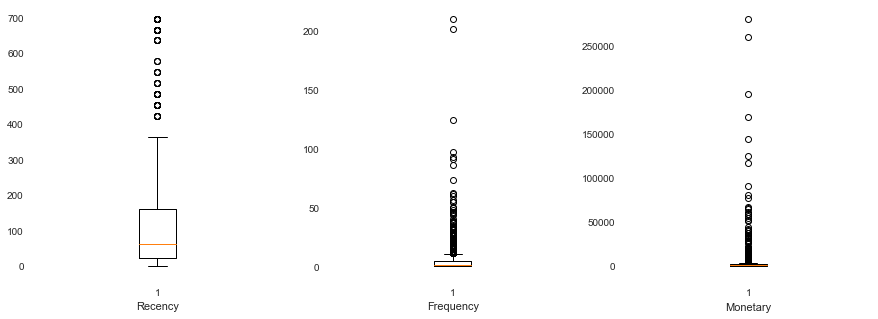

In [36]:
### Visualization
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.boxplot(df_RFM['Recency'])
plt.xlabel('Recency')
plt.subplot(1, 3, 2)
plt.boxplot(df_RFM['Frequency'])
plt.xlabel('Frequency')
plt.subplot(1, 3, 3)
plt.boxplot(df_RFM['Monetary'])
plt.xlabel('Monetary')
plt.show()

In [37]:
# Calculate numbers of outliers
Lib.count_outliers(df_RFM)

{'Recency': [0, 74, 4265],
 'Frequency': [0, 53, 4286],
 'Monetary': [0, 31, 4308]}

- 3 biến Recency, Frequency, Monetary đều có upper outliers, số lượng outliers nhỏ => Ta sẽ cân nhắc việc có loại bỏ outliers hay ko khi xây dựng model

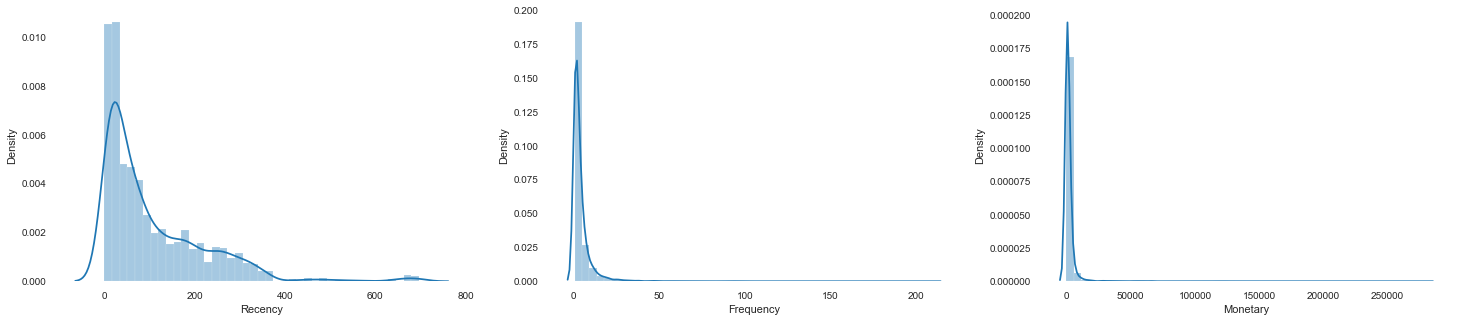

In [38]:
### Visualization
plt.figure(figsize=(25,5))
plt.subplot(1, 3, 1)
sns.distplot(df_RFM['Recency'])
plt.subplot(1, 3, 2)
sns.distplot(df_RFM['Frequency'])
plt.subplot(1, 3, 3)
sns.distplot(df_RFM['Monetary'])
plt.show()

- 3 biến Recency, Frequency, Monetary đều có phân phối không phải phân phối chuẩn => Ta sẽ cân nhắc lựa chọn scaler phù hợp.

## 2.4 Hopkins Statistic

In [43]:
hopkins(df_RFM, df_RFM.shape[0])

0.007054673079424211

Hopkins score = 0.007 rất nhỏ so với 0.25 => Có thể khẳng định rằng data phù hợp với việc phân cụm 

# Step 3: Modeling

## 3.1 Manual RFM

In [51]:
# Create labels for Recency, Frequency, Monetary & Assign them to 5 equal percentile groups and convert their labels from categorical to integer
r_groups = pd.qcut(df_RFM['Recency'].rank(method='first'), q=5, labels=range(5, 0, -1))
f_groups = pd.qcut(df_RFM['Frequency'].rank(method='first'), q=5, labels=range(1,6))
m_groups = pd.qcut(df_RFM['Monetary'].rank(method='first'), q=5, labels=range(1,6))

In [52]:
# Create new columns R, F, M
df_RFM = df_RFM.assign(R=r_groups, F=f_groups, M=m_groups)
df_RFM.head()

Recency  Frequency   Monetary  R  F  M  RFM_Segment
CustomerID                                                     
14646.0           2         74  280206.02  5  5  5          555
18102.0          12         60  259657.30  5  5  5          555
17450.0           3         46  194390.79  5  5  5          555
16446.0          89          2  168472.50  2  2  5          225
14911.0           0        201  143711.17  5  5  5          555

In [53]:
# Calculate RFM Segment
df_RFM['RFM_Segment'] = (df_RFM.R.astype(str) + df_RFM.F.astype(str) + df_RFM.M.astype(str)).astype(int)
df_RFM.head()

Recency  Frequency   Monetary  R  F  M  RFM_Segment
CustomerID                                                     
14646.0           2         74  280206.02  5  5  5          555
18102.0          12         60  259657.30  5  5  5          555
17450.0           3         46  194390.79  5  5  5          555
16446.0          89          2  168472.50  2  2  5          225
14911.0           0        201  143711.17  5  5  5          555

In [54]:
df_RFM.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4339 entries, 14646.0 to 13256.0
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Recency      4339 non-null   int64   
 1   Frequency    4339 non-null   int64   
 2   Monetary     4339 non-null   float64 
 3   R            4339 non-null   category
 4   F            4339 non-null   category
 5   M            4339 non-null   category
 6   RFM_Segment  4339 non-null   int64   
dtypes: category(3), float64(1), int64(3)
memory usage: 182.6 KB


In [114]:
segment_dict = {'Best Customers' : [555, 554, 544, 545, 454, 455, 445],
                'Loyal Customers' : [543, 444, 435, 355, 354, 345, 344, 335, 553, 535, 534, 443],
                'Potential Loyalist': [551, 552, 541, 542, 533, 532, 531, 452, 451, 442, 441, 431, 453, 433, 432, 423, 353, 352, 351, 342
                                       , 341, 333, 323, 434, 343, 334,
                                      525, 524, 523, 522, 521, 515, 514, 513, 425, 424, 413,414,415, 315, 314, 313, 325, 324],
                'New Customers' : [512, 511, 422, 421, 412, 411, 311],
#                 'Promising' : [525, 524, 523, 522, 521, 515, 514, 513, 425, 424, 413,414,415, 315, 314, 313, 325, 324],
                'Hibernating Customers' : [331, 321, 312, 221, 213, 231, 241, 251, 332, 322, 233, 232, 223, 222, 132, 123, 122, 212, 211], 
                'At Risk' : [255, 254, 245, 244, 253, 252, 243, 242, 235, 234, 225, 224, 153, 152, 145, 143, 142, 135, 134, 133, 125, 124],
                'Cannot Lose Them' : [155, 154, 144, 214,215,115, 114, 113],
                'Lost Customers' : [111, 112, 121, 131,141,151]}

In [115]:
df_RFM['RFM_Cluster'] = df_RFM['RFM_Segment'].apply(lambda x: [k for k,v in segment_dict.items() if x in v][0])

In [116]:
df_RFM.head()

Recency  Frequency   Monetary  R  F  M  RFM_Segment  \
CustomerID                                                        
14646.0           2         74  280206.02  5  5  5          555   
18102.0          12         60  259657.30  5  5  5          555   
17450.0           3         46  194390.79  5  5  5          555   
16446.0          89          2  168472.50  2  2  5          225   
14911.0           0        201  143711.17  5  5  5          555   

               RFM_Cluster  
CustomerID                  
14646.0     Best Customers  
18102.0     Best Customers  
17450.0     Best Customers  
16446.0            At Risk  
14911.0     Best Customers

In [117]:
df_RFM.RFM_Cluster.value_counts()

Hibernating Customers    865
Best Customers           818
Potential Loyalist       805
Lost Customers           558
Loyal Customers          528
At Risk                  449
New Customers            191
Cannot Lose Them         125
Name: RFM_Cluster, dtype: int64

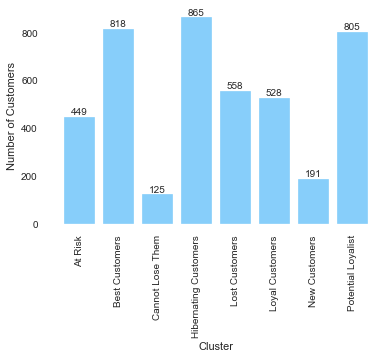

In [155]:
count= Lib.df_RFM.groupby(df_RFM.RFM_Cluster).size()
visualization_countplot(count)

- Có thể nhận thấy dữ liệu được phân tương đối tốt, các cluster không bị quá imbalanced

In [119]:
rfm_agg = Lib.create_df_agg(df_RFM, 'RFM_Cluster')
rfm_agg

RFM_Cluster  RecencyMean  FrequencyMean  MonetaryMean  RMean  \
0                At Risk        160.0            4.0        1927.0    2.0   
1         Best Customers         15.0           12.0        6745.0    5.0   
2       Cannot Lose Them        268.0            2.0        1905.0    1.0   
3  Hibernating Customers        127.0            1.0         343.0    2.0   
4         Lost Customers        310.0            1.0         220.0    1.0   
5        Loyal Customers         39.0            5.0        2211.0    4.0   
6          New Customers         29.0            1.0         241.0    4.0   
7     Potential Loyalist         38.0            2.0         787.0    4.0   

   FMean  MMean  Count  Percent  
0    4.0    4.0    449    10.35  
1    5.0    5.0    818    18.85  
2    1.0    4.0    125     2.88  
3    2.0    2.0    865    19.94  
4    2.0    1.0    558    12.86  
5    4.0    4.0    528    12.17  
6    1.0    1.0    191     4.40  
7    3.0    3.0    805    18.55

Cluster description:
- 'Best Customers' : Khách hàng chi tiêu nhiều nhất, thường xuyên nhất và vẫn đang mua hàng trong thời gian gần đây (R,F,M từ 4-5)
- 'Loyal Customers' : Khách hàng có mức chi tiêu, số lần mua sắm từ trung bình đến cao và mua hàng trong thời gian gần đây (3-5)
- 'Potential Loyalist': Khách hàng mua sắm tương đối thường xuyên, vẫn mua hàng trong thời gian gần đây, mức chi tiêu trung bình đến cao
- New Customers' : Khách hàng mới bắt đầu mua hàng trong thời gian gần đây, số đơn hàng còn ít và tổng chi tiêu thấp
- 'Hibernating Customers' : Khách hàng có mức chi tiêu, số lần mua hàng trung bình đến thấp, và lần mua hàng gần nhất khá xa
- 'At Risk' : Khách hàng chi tiêu trung bình đến cao, mua hàng khá thường xuyên nhưng đã lâu không mua hàng
- 'Cannot Lose Them' : Khách hàng có mức chi tiêu khá và cao nhưng đã lâu không mua hàng và không mua thường xuyên 
- 'Lost Customers' : Khách hàng đã rời bỏ

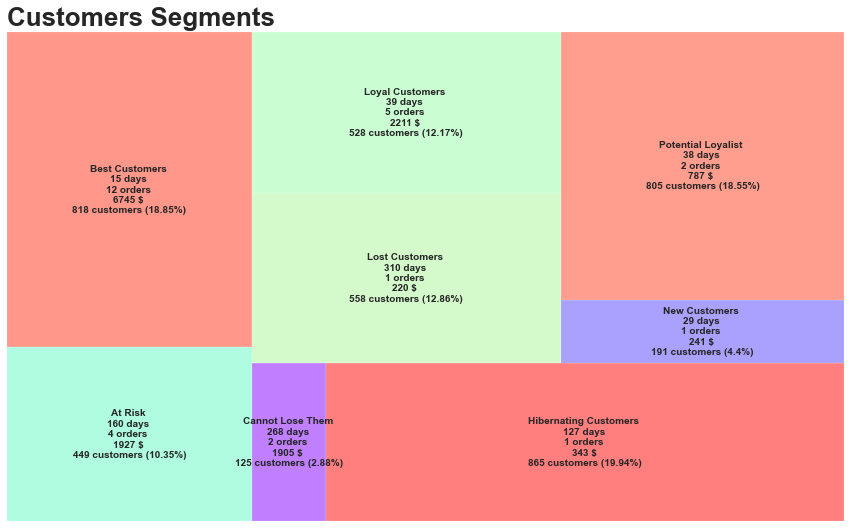

In [121]:
Lib.treemap_customer_segmentation_rfm(rfm_agg.iloc[:,[0,1,2,3,7,8]], font_size=10)

In [122]:
# Visualization - 2D Scatter
fig = px.scatter(rfm_agg, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="RFM_Cluster",
           hover_name="RFM_Cluster", size_max=80)
fig.show()

In [123]:
# Visualization - 3D scatter
df_RFM_log = df_RFM.copy()
df_RFM_log['Recency'] = np.log(df_RFM_log['Recency'])
df_RFM_log['Frequency'] = np.log(df_RFM_log['Frequency'])
df_RFM_log['Monetary'] = np.log(df_RFM_log['Monetary'])

fig = px.scatter_3d(df_RFM_log, x='Recency', y='Frequency', z='Monetary',
                    color = 'RFM_Cluster', opacity=0.5)
fig.update_traces(marker=dict(size=5),selector=dict(mode='markers'))
fig.show()

Từ 3D Scatter ta thấy với phương pháp Manual RFM, các nhóm dữ liệu tách biệt khá tốt với nhau.

## Original data

### 3.2 K-Means

In [125]:
df_RFM.head(3)

Recency  Frequency   Monetary  R  F  M  RFM_Segment  \
CustomerID                                                        
14646.0           2         74  280206.02  5  5  5          555   
18102.0          12         60  259657.30  5  5  5          555   
17450.0           3         46  194390.79  5  5  5          555   

               RFM_Cluster  
CustomerID                  
14646.0     Best Customers  
18102.0     Best Customers  
17450.0     Best Customers

In [126]:
df_RFM2 = df_RFM[['Recency','Frequency','Monetary','R','F','M']]
df_RFM2.head(3)

Recency  Frequency   Monetary  R  F  M
CustomerID                                        
14646.0           2         74  280206.02  5  5  5
18102.0          12         60  259657.30  5  5  5
17450.0           3         46  194390.79  5  5  5

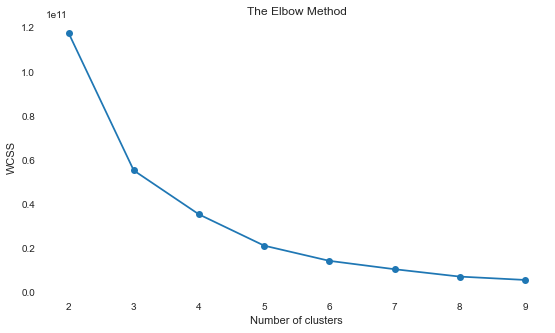

In [250]:
# Select k using Elbow method
plt.figure(figsize=(9,5))
wcss = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters = k, random_state=42)
    kmeans.fit(df_RFM2[['Recency','Frequency','Monetary']])
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 10), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Chọn k=4 vì nằm ở vị trí elbow và từ k=5 trở đi độ dốc của đường line giảm dần

In [143]:
# Build model with k=4
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_RFM2[['Recency','Frequency','Monetary']])

KMeans(n_clusters=4)

In [147]:
df_RFM2['KMeans_Cluster'] = kmeans.labels_
df_RFM2.head()

Recency  Frequency   Monetary  R  F  M  KMeans_segment  \
CustomerID                                                           
14646.0           2         74  280206.02  5  5  5               3   
18102.0          12         60  259657.30  5  5  5               3   
17450.0           3         46  194390.79  5  5  5               1   
16446.0          89          2  168472.50  2  2  5               1   
14911.0           0        201  143711.17  5  5  5               1   

            KMeans_Cluster  
CustomerID                  
14646.0                  3  
18102.0                  3  
17450.0                  1  
16446.0                  1  
14911.0                  1

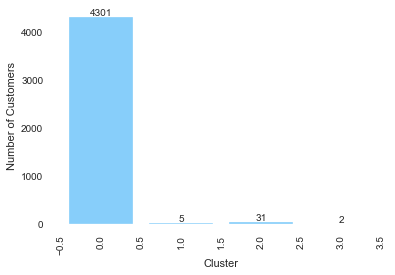

In [159]:
count = df_RFM2.groupby(df_RFM2.KMeans_Cluster).size()
visualization_countplot(count)

- Kết quả cho thấy: hầu hết dữ liệu tập trung ở 1 cluster => Phân cụm không hiệu quả => Thuật toán K-Means trên dữ liệu gốc không phù hợp

### 3.3 Gaussian Mixture Model

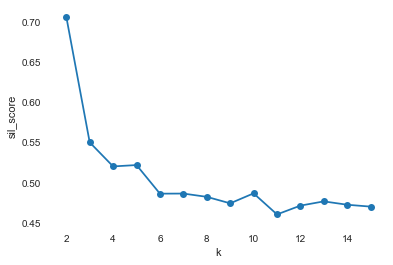

In [163]:
# Find suitable k 
list_sil = []
for k in range(2,10):
    gmm = GaussianMixture(n_components=k, covariance_type='spherical', random_state=42)
    gmm.fit(df_RFM2[['Recency','Frequency','Monetary']])
    labels = gmm.predict(df_RFM2[['Recency','Frequency','Monetary']])
    sil = metrics.silhouette_score(df_RFM2[['Recency','Frequency','Monetary']], labels, metric='euclidean')
    list_sil.append(sil)
plt.plot(range(2,10), list_sil, marker='o')
plt.xlabel('k')
plt.ylabel('sil_score')
plt.show()

Chọn k=2, vì với k=2 thì silhouette score có giá trị cao nhất

In [164]:
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(df_RFM2[['Recency','Frequency','Monetary']])

GaussianMixture(n_components=2, random_state=42)

In [165]:
gmm_segment = gmm.predict(df_RFM2[['Recency','Frequency','Monetary']])
df_RFM2['GMM_Cluster'] = gmm_segment
df_RFM2.head()

Recency  Frequency   Monetary  R  F  M  KMeans_segment  \
CustomerID                                                           
14646.0           2         74  280206.02  5  5  5               3   
18102.0          12         60  259657.30  5  5  5               3   
17450.0           3         46  194390.79  5  5  5               1   
16446.0          89          2  168472.50  2  2  5               1   
14911.0           0        201  143711.17  5  5  5               1   

            KMeans_Cluster  GMM_Cluster  
CustomerID                               
14646.0                  3            1  
18102.0                  3            1  
17450.0                  1            1  
16446.0                  1            1  
14911.0                  1            1

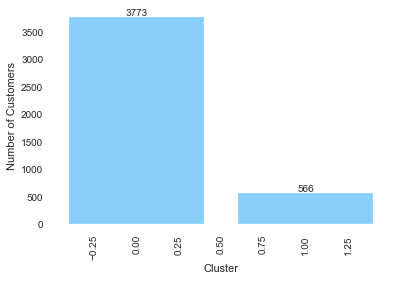

In [201]:
count = df_RFM2.groupby('GMM_Cluster').size()
visualization_countplot(count)

- So với KMeans, GMM phân chia dữ liệu vào các cluster tốt hơn một chút nhưng vẫn imbalanced 

In [170]:
gmm_agg = Lib.create_df_agg(df_RFM2, 'GMM_Cluster')
gmm_agg

GMM_Cluster  RecencyMean  FrequencyMean  MonetaryMean  RMean  FMean  MMean  \
0            0        117.0            3.0         825.0    3.0    3.0    3.0   
1            1         27.0           15.0       10199.0    4.0    5.0    5.0   

   Count  Percent  
0   3773    86.96  
1    566    13.04

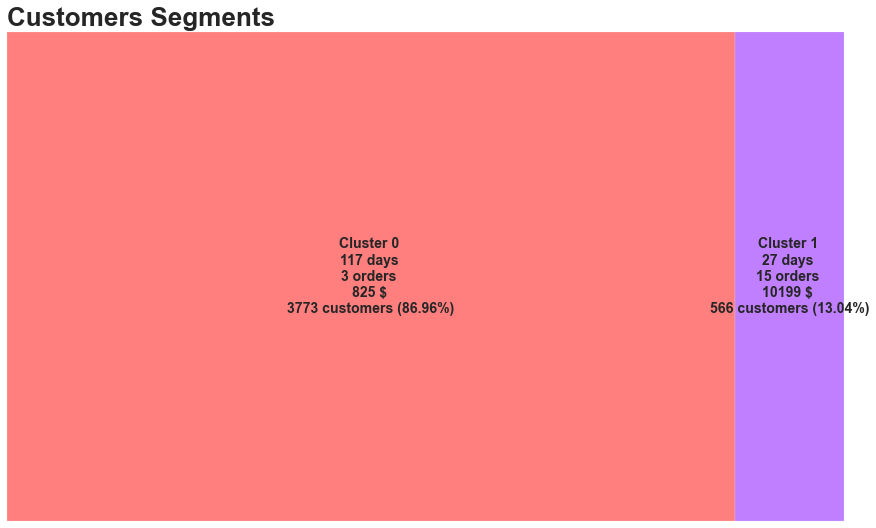

In [169]:
Lib.treemap_customer_segmentation(gmm_agg.iloc[:,[0,1,2,3,7,8]],font_size=14)

### 3.4 Hierarchical

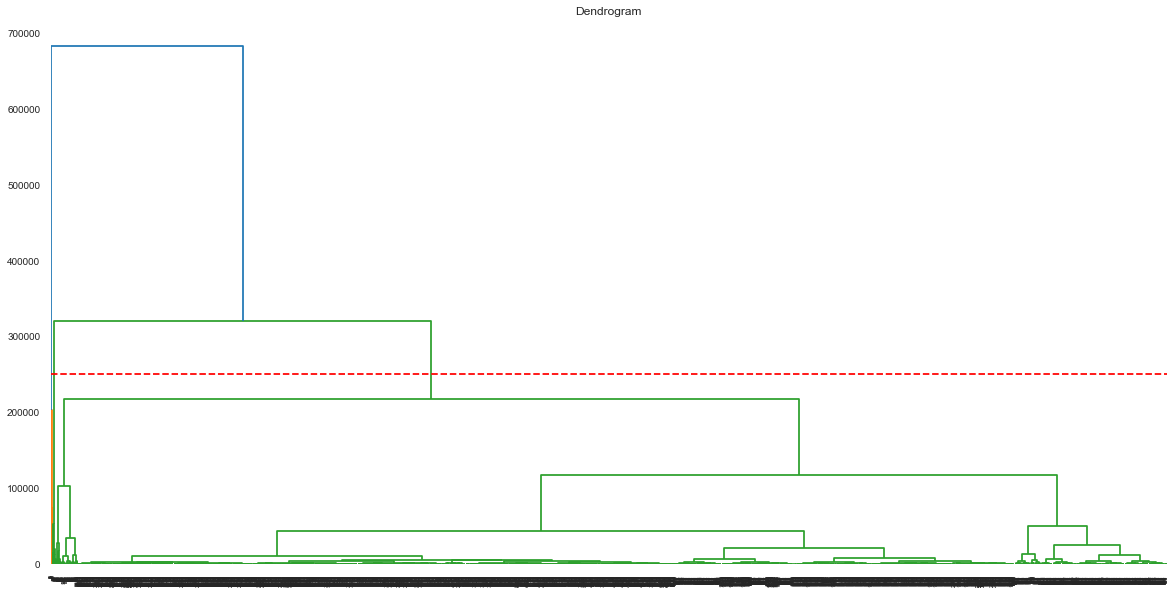

In [251]:
# Dendrogram
plt.figure(figsize=(20,10))
plt.title('Dendrogram')
dend = hierarchy.dendrogram(hierarchy.linkage(df_RFM2[['Recency','Frequency','Monetary']], method='ward'))
plt.axhline(y=250000, color='r', linestyle='--')
plt.show()

In [252]:
# Chọn k=3 
hierarchical = AgglomerativeClustering(n_clusters=3,
                       linkage='ward',
                       affinity='euclidean')
hierarchical.fit(df_RFM2[['Recency','Frequency','Monetary']])

AgglomerativeClustering(n_clusters=3)

In [253]:
df_RFM2['Hierar_Cluster'] = hierarchical.labels_
df_RFM2.head()

Recency  Frequency   Monetary  R  F  M  KMeans_segment  \
CustomerID                                                           
14646.0           2         74  280206.02  5  5  5               3   
18102.0          12         60  259657.30  5  5  5               3   
17450.0           3         46  194390.79  5  5  5               1   
16446.0          89          2  168472.50  2  2  5               1   
14911.0           0        201  143711.17  5  5  5               1   

            KMeans_Cluster  GMM_Cluster  Hierarchical_segment  r_Recency  \
CustomerID                                                                 
14646.0                  3            1                     1  -0.422939   
18102.0                  3            1                     1  -0.351254   
17450.0                  1            1                     1  -0.415771   
16446.0                  1            1                     1   0.200717   
14911.0                  1            1                     1  -0.437276   

            r_Frequency  r_Monetary  Hierar_Cluster  
CustomerID                                           
14646.0           18.00  206.474421               1  
18102.0           14.50  191.296545               1  
17450.0           11.00  143.088820               1  
16446.0            0.00  123.944824               1  
14911.0           49.75  105.655393               1

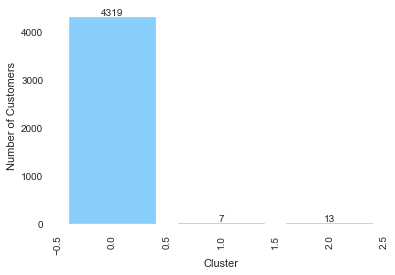

In [254]:
count = df_RFM2.groupby(df_RFM2.Hierar_Cluster).size()
visualization_countplot(count)

Comment:
- Hầu hết dữ liệu tập trung ở 1 cluster => Thuật toán Hierarchical trên dữ liệu gốc không phù hợp

## Scaled Data

### 3.5 K-Means

In [297]:
# Scale data on 3 columns 'Recency','Frequency','Monetary'
df_RFM3 = df_RFM[['Recency', 'Frequency', 'Monetary']]
df_RFM3_scaled = df_RFM3.copy()
scaler = RobustScaler()
df_RFM3_scaled[['Recency','Frequency','Monetary']] = scaler.fit_transform(df_RFM3_scaled[['Recency','Frequency','Monetary']])
df_RFM3_scaled.head()

Recency  Frequency    Monetary
CustomerID                                 
14646.0    -0.422939      18.00  206.474421
18102.0    -0.351254      14.50  191.296545
17450.0    -0.415771      11.00  143.088820
16446.0     0.200717       0.00  123.944824
14911.0    -0.437276      49.75  105.655393

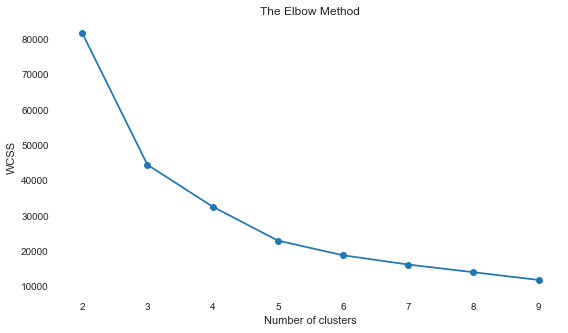

In [298]:
# Select k using Elbow method
plt.figure(figsize=(9,5))
wcss = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters = k, random_state=42)
    kmeans.fit(df_RFM3_scaled[['Recency','Frequency','Monetary']])
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 10), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Chọn k=3 vì nằm ở vị trí elbow, và từ k=4 trở đi độ dốc của đường line giảm dần

In [301]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_RFM3_scaled)

KMeans(n_clusters=3)

In [302]:
df_RFM3['KMeans_Cluster'] = kmeans.labels_
df_RFM3.head()

Recency  Frequency   Monetary  KMeans_Cluster
CustomerID                                               
14646.0           2         74  280206.02               1
18102.0          12         60  259657.30               1
17450.0           3         46  194390.79               1
16446.0          89          2  168472.50               1
14911.0           0        201  143711.17               1

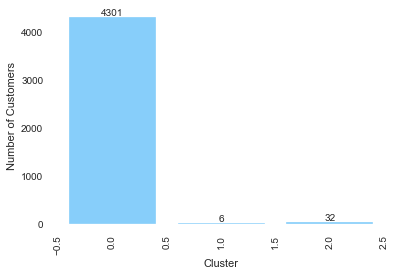

In [303]:
count = df_RFM3.groupby('KMeans_Cluster').size()
visualization_countplot(count)

K-Means trên scaled data vẫn cho kết quả phân cụm không hiệu quả, dữ liệu tập trung chủ yếu ở 1 cluster.

### 3.6 Gaussian Mixture Model

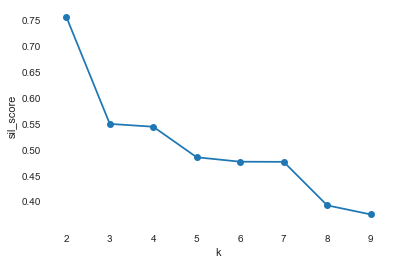

In [304]:
# Find suitable k 
list_sil = []
for k in range(2,10):
    gmm = GaussianMixture(n_components=k, covariance_type='spherical', random_state=42)
    gmm.fit(df_RFM3_scaled[['Recency','Frequency','Monetary']])
    labels = gmm.predict(df_RFM3_scaled[['Recency','Frequency','Monetary']])
    sil = metrics.silhouette_score(df_RFM3_scaled[['Recency','Frequency','Monetary']], labels, metric='euclidean')
    list_sil.append(sil)
plt.plot(range(2,10), list_sil, marker='o')
plt.xlabel('k')
plt.ylabel('sil_score')
plt.show()

Chọn k=2 vì với k=2 silhouette có giá trị cao nhất 

In [305]:
# Select k=2
gmm = GaussianMixture(n_components=2)
gmm.fit(df_RFM3_scaled[['Recency', 'Frequency', 'Monetary']])

GaussianMixture(n_components=2)

In [306]:
df_RFM3['GMM_Cluster'] = gmm.predict(df_RFM3_scaled[['Recency', 'Frequency', 'Monetary']])
df_RFM3.head()

Recency  Frequency   Monetary  KMeans_Cluster  GMM_Cluster
CustomerID                                                            
14646.0           2         74  280206.02               1            1
18102.0          12         60  259657.30               1            1
17450.0           3         46  194390.79               1            1
16446.0          89          2  168472.50               1            1
14911.0           0        201  143711.17               1            1

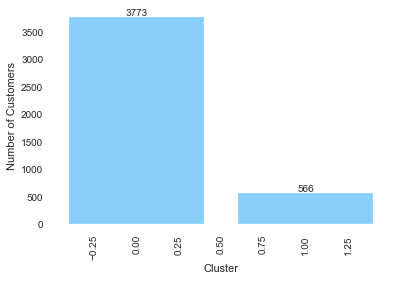

In [307]:
count = df_RFM3.groupby('GMM_Cluster').size()
visualization_countplot(count)

GMM trên scaled data cho kết quả không khác biệt so với original data => imbalanced

### 3.7 Hierarchical

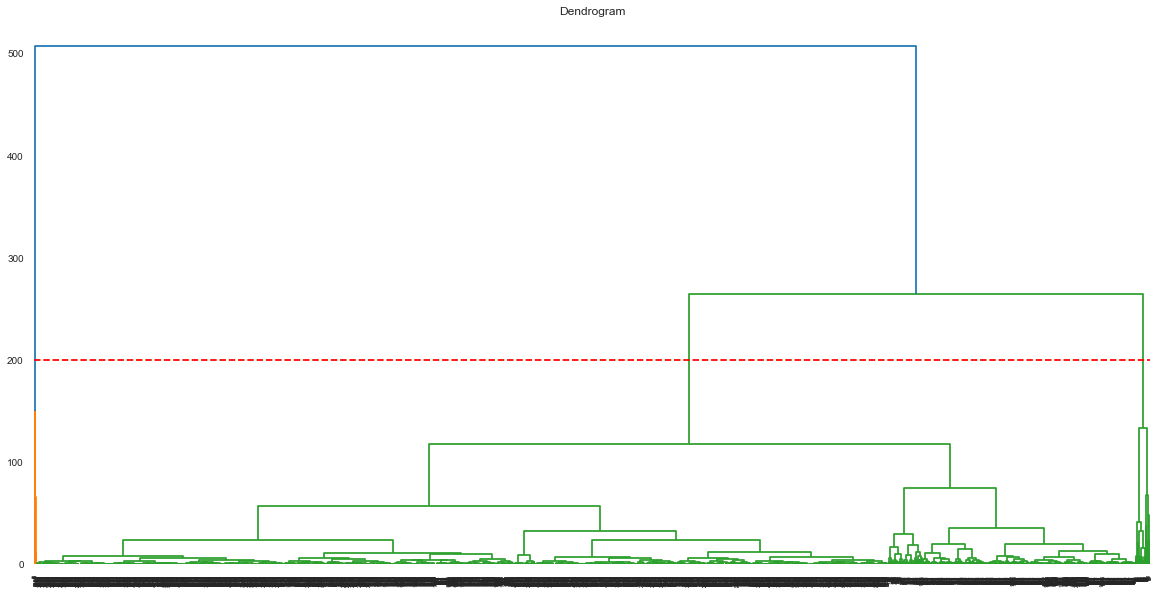

In [308]:
# Dendrogram
plt.figure(figsize=(20,10))
plt.title('Dendrogram')
dend = hierarchy.dendrogram(hierarchy.linkage(df_RFM3_scaled[['Recency','Frequency','Monetary']], method='ward'))
plt.axhline(y=200, color='r', linestyle='--')
plt.show()

In [309]:
# Select k=3
hierarchical = AgglomerativeClustering(n_clusters=3,
                       linkage='ward',
                       affinity='euclidean')
hierarchical .fit(df_RFM3_scaled[['Recency','Frequency','Monetary']])

AgglomerativeClustering(n_clusters=3)

In [310]:
df_RFM3['Hierar_Cluster'] = hierarchical.labels_
df_RFM3.head()

Recency  Frequency   Monetary  KMeans_Cluster  GMM_Cluster  \
CustomerID                                                               
14646.0           2         74  280206.02               1            1   
18102.0          12         60  259657.30               1            1   
17450.0           3         46  194390.79               1            1   
16446.0          89          2  168472.50               1            1   
14911.0           0        201  143711.17               1            1   

            Hierar_Cluster  
CustomerID                  
14646.0                  0  
18102.0                  0  
17450.0                  0  
16446.0                  0  
14911.0                  0

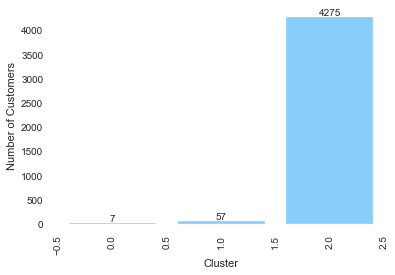

In [311]:
count = df_RFM3.groupby('Hierar_Cluster').size()
visualization_countplot(count)

Hierarchical trên scaled data cho kết quả phân cụm không khác biệt là mấy so với original data

## Non-outliers Data
- Ta sẽ tiến hành loại bỏ outliers, MinMaxScaler và thực hiện phân cụm trên Non-Outliers Data

In [312]:
df_RFM.head(3)

Recency  Frequency   Monetary  R  F  M  RFM_Segment  \
CustomerID                                                        
14646.0           2         74  280206.02  5  5  5          555   
18102.0          12         60  259657.30  5  5  5          555   
17450.0           3         46  194390.79  5  5  5          555   

               RFM_Cluster  
CustomerID                  
14646.0     Best Customers  
18102.0     Best Customers  
17450.0     Best Customers

In [275]:
df_RFM4 = df_RFM[['Recency', 'Frequency', 'Monetary', 'R', 'F', 'M']]

In [276]:
df_RFM_no, df_outlier, max_m, max_f, max_r = Lib.drop_outliers(df_RFM4)

In [277]:
df_RFM_no.shape

(4202, 6)

In [278]:
df_RFM_no.head()

Recency  Frequency  Monetary  R  F  M
CustomerID                                       
14680.0          26         16  28754.11  4  5  5
13081.0          12         11  28337.38  5  5  5
17857.0          18         23  26879.04  5  5  5
16333.0         124         22  26626.80  2  5  5
12753.0          23          6  21429.39  4  4  5

In [279]:
df_RFM_no_scaled = df_RFM_no.copy()
scaler = MinMaxScaler()
df_RFM_no_scaled[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(df_RFM_no_scaled[['Recency', 'Frequency', 'Monetary']])
df_RFM_no_scaled.head()

Recency  Frequency  Monetary  R  F  M
CustomerID                                        
14680.0     0.061321   0.576923  1.000000  4  5  5
13081.0     0.028302   0.384615  0.985507  5  5  5
17857.0     0.042453   0.846154  0.934789  5  5  5
16333.0     0.292453   0.807692  0.926017  2  5  5
12753.0     0.054245   0.192308  0.745264  4  4  5

### 3.8 K-Means

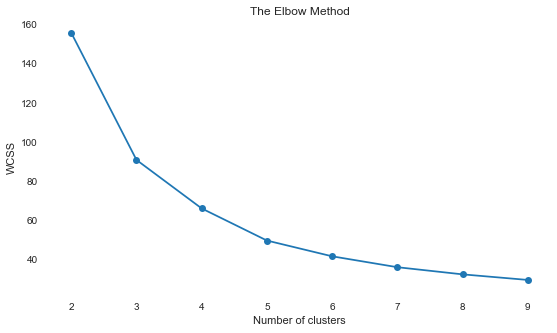

In [296]:
# Select k using Elbow method
plt.figure(figsize=(9,5))
wcss = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters = k, random_state=42)
    kmeans.fit(df_RFM_no_scaled[['Recency','Frequency','Monetary']])
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 10), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Chọn k=4 ở vị trí elbow, và từ k=5 độ dốc của đường line giảm dần

In [324]:
sil_KMeans = metrics.silhouette_score(df_RFM_no_scaled[['Recency','Frequency','Monetary']],
                                      kmeans.labels_, metric='euclidean')
sil_KMeans

0.4735364836279647

In [319]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_RFM_no_scaled[['Recency', 'Frequency', 'Monetary']])

KMeans(n_clusters=4)

In [320]:
df_RFM_no['KMeans_Cluster'] = kmeans.labels_
df_RFM_no.head()

Recency  Frequency  Monetary  R  F  M  KMeans_Cluster  GMM_Cluster
CustomerID                                                                    
14680.0          26         16  28754.11  4  5  5               3            0
13081.0          12         11  28337.38  5  5  5               3            0
17857.0          18         23  26879.04  5  5  5               3            0
16333.0         124         22  26626.80  2  5  5               3            0
12753.0          23          6  21429.39  4  4  5               3            0

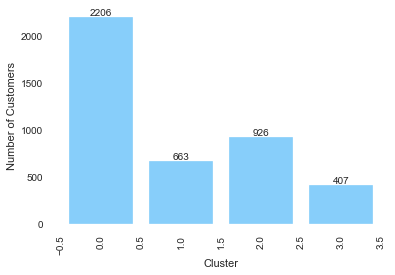

In [321]:
count = df_RFM_no.groupby(df_RFM_no.KMeans_Cluster).size()
visualization_countplot(count)

Kết quả phân cụm của Kmeans trên Scaled Non-outliers data khá tốt

In [285]:
kmm_agg_no = Lib.create_df_agg(df_RFM_no, 'KMeans_Cluster')
kmm_agg_no

KMeans_Cluster  RecencyMean  FrequencyMean  MonetaryMean  RMean  FMean  \
0               0        284.0            1.0         437.0    1.0    2.0   
1               1         24.0           13.0        5614.0    4.0    5.0   
2               2         39.0            3.0        1170.0    4.0    3.0   
3               3        155.0            2.0         715.0    2.0    2.0   

   MMean  Count  Percent  
0    2.0    604    14.37  
1    5.0    414     9.85  
2    3.0   2261    53.81  
3    2.0    923    21.97

Từ các chỉ số RMean, FMean, MMean ta thấy mỗi nhóm có một "đặc trưng" khác nhau rất rõ rệt

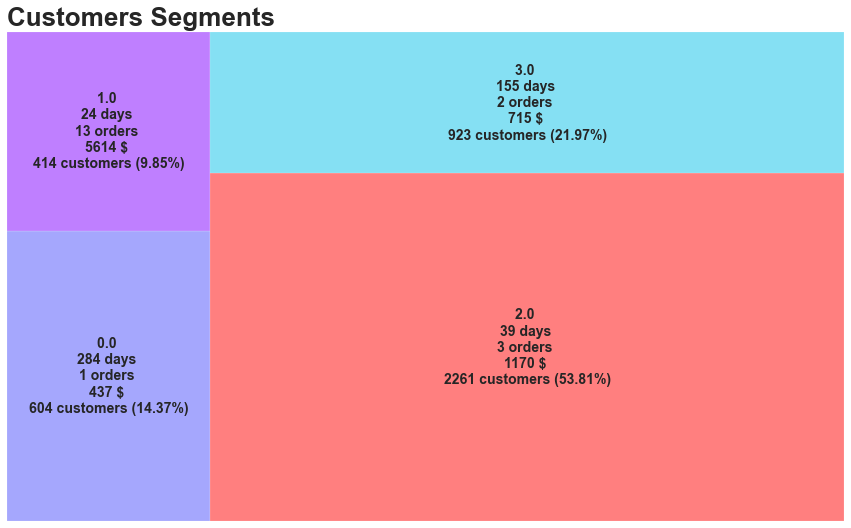

In [286]:
treemap_customer_segmentation(kmm_agg_no.iloc[:,[0,1,2,3,7,8]],14)

In [288]:
# Visualization - 2D Scatter
fig = px.scatter(kmm_agg_no, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="KMeans_Cluster",
           hover_name="KMeans_Cluster", size_max=80)
fig.show()

In [289]:
# Visualization - 3D scatter
df_RFM_no_log = df_RFM_no.copy()
df_RFM_no_log['Recency'] = np.log(df_RFM_no_log['Recency'])
df_RFM_no_log['Frequency'] = np.log(df_RFM_no_log['Frequency'])
df_RFM_no_log['Monetary'] = np.log(df_RFM_no_log['Monetary'])

fig = px.scatter_3d(df_RFM_no_log, x='Recency', y='Frequency', z='Monetary',
                    color = 'KMeans_Cluster', opacity=0.5)
fig.update_traces(marker=dict(size=5),selector=dict(mode='markers'))
fig.show()

Từ biểu đồ 3D Scatter ta thấy, các nhóm dữ liệu tách biệt rất rõ ràng 

### 3.9 Gaussian Mixture Model

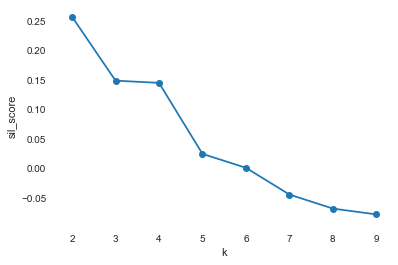

In [333]:
# Find suitable k 
list_sil = []
for k in range(2,10):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(df_RFM_no_scaled[['Recency','Frequency','Monetary']])
    labels = gmm.predict(df_RFM_no_scaled[['Recency','Frequency','Monetary']])
    sil = metrics.silhouette_score(df_RFM_no_scaled[['Recency','Frequency','Monetary']], labels, metric='euclidean')
    list_sil.append(sil)
plt.plot(range(2,10), list_sil, marker='o')
plt.xlabel('k')
plt.ylabel('sil_score')
plt.show()

In [334]:
# Select k=2
gmm = GaussianMixture(n_components=2)
gmm.fit(df_RFM_no_scaled[['Recency', 'Frequency', 'Monetary']])

GaussianMixture(n_components=2)

In [335]:
labels = gmm.predict(df_RFM_no_scaled[['Recency', 'Frequency', 'Monetary']])
sil_GMM = metrics.silhouette_score(df_RFM_no_scaled[['Recency','Frequency','Monetary']], 
                                   labels, metric='euclidean')
sil_GMM

0.2571101067896347

In [336]:
df_RFM_no['GMM_Cluster'] = gmm.predict(df_RFM_no_scaled[['Recency', 'Frequency', 'Monetary']])
df_RFM_no.head()

Recency  Frequency  Monetary  R  F  M  KMeans_Cluster  GMM_Cluster
CustomerID                                                                    
14680.0          26         16  28754.11  4  5  5               3            1
13081.0          12         11  28337.38  5  5  5               3            1
17857.0          18         23  26879.04  5  5  5               3            1
16333.0         124         22  26626.80  2  5  5               3            1
12753.0          23          6  21429.39  4  4  5               3            1

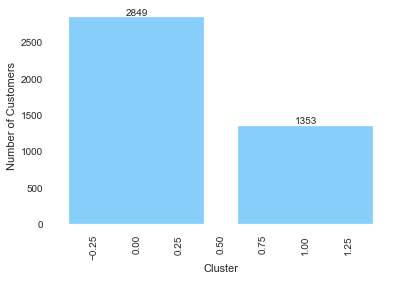

In [337]:
count = df_RFM_no.groupby(df_RFM_no.GMM_Cluster).size()
visualization_countplot(count)

In [338]:
gmm_agg_no = Lib.create_df_agg(df_RFM_no, 'GMM_Cluster')
gmm_agg_no

GMM_Cluster  RecencyMean  FrequencyMean  MonetaryMean  RMean  FMean  MMean  \
0            0        124.0            2.0         505.0    3.0    2.0    2.0   
1            1         43.0            8.0        3293.0    4.0    4.0    5.0   

   Count  Percent  
0   2849     67.8  
1   1353     32.2

In [340]:
# Visualization - 2D Scatter
fig = px.scatter(gmm_agg_no, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="GMM_Cluster",
           hover_name="GMM_Cluster", size_max=80)
fig.show()

In [344]:
# Visualization - 3D scatter
df_RFM_no_log = df_RFM_no.copy()
df_RFM_no_log['Recency'] = np.log(df_RFM_no_log['Recency'])
df_RFM_no_log['Frequency'] = np.log(df_RFM_no_log['Frequency'])
df_RFM_no_log['Monetary'] = np.log(df_RFM_no_log['Monetary'])

fig = px.scatter_3d(df_RFM_no_log, x='Recency', y='Frequency', z='Monetary',
                    color = 'GMM_Cluster', opacity=0.5)
fig.update_traces(marker=dict(size=5),selector=dict(mode='markers'))
fig.show()

Thuật toán GMM cho kết quả phân cụm khá tốt, tuy nhiên với số cụm bằng 2 thì trên thực tế việc phân chia nhóm khách hàng không mang nhiều ý nghĩa. Nên ta sẽ không ưu tiên option này.

### 3.10 Hierarchical

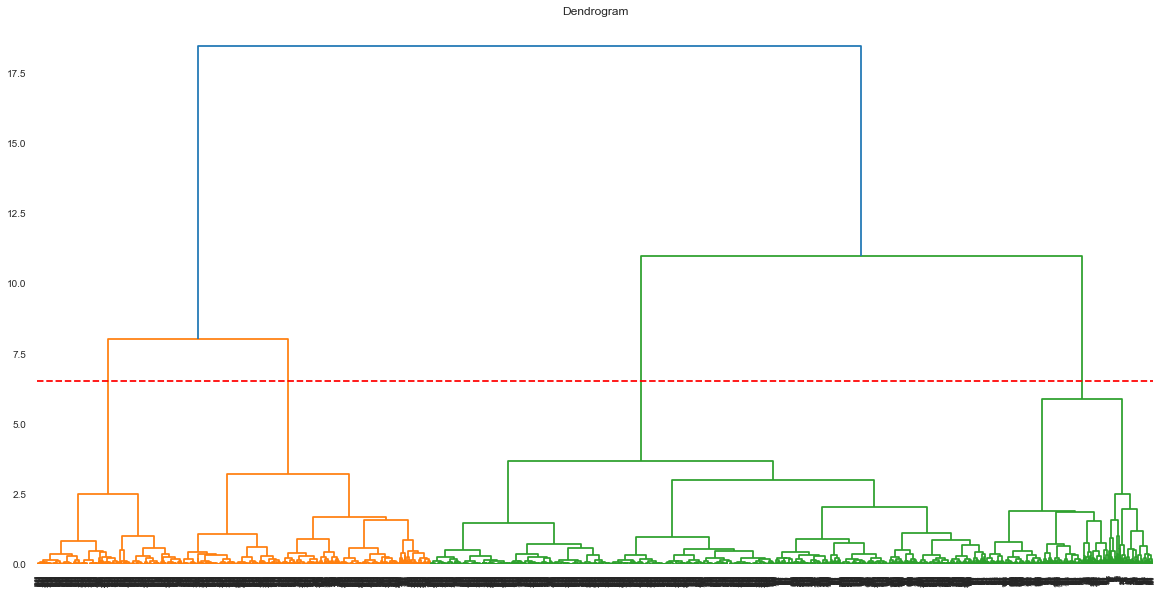

In [349]:
# Dendrogram
plt.figure(figsize=(20,10))
plt.title('Dendrogram')
dend = hierarchy.dendrogram(hierarchy.linkage(df_RFM_no_scaled[['Recency','Frequency','Monetary']], method='ward'))
plt.axhline(y=6.5, color='r', linestyle='--')
plt.show()

In [347]:
# Select k=4
hierarchical = AgglomerativeClustering(n_clusters=4,
                       linkage='ward',
                       affinity='euclidean')
hierarchical.fit(df_RFM_no_scaled[['Recency','Frequency','Monetary']])

AgglomerativeClustering(n_clusters=4)

In [357]:
sil_Hierar = metrics.silhouette_score(df_RFM_no_scaled[['Recency','Frequency','Monetary']],
                                      hierarchical.labels_, metric='euclidean')
sil_Hierar

0.4705420235018778

In [348]:
df_RFM_no['Hierar_Cluster'] = hierarchical.labels_
df_RFM_no.head()

Recency  Frequency  Monetary  R  F  M  KMeans_Cluster  \
CustomerID                                                          
14680.0          26         16  28754.11  4  5  5               3   
13081.0          12         11  28337.38  5  5  5               3   
17857.0          18         23  26879.04  5  5  5               3   
16333.0         124         22  26626.80  2  5  5               3   
12753.0          23          6  21429.39  4  4  5               3   

            GMM_Cluster  Hierar_Cluster  
CustomerID                               
14680.0               1               0  
13081.0               1               0  
17857.0               1               0  
16333.0               1               0  
12753.0               1               0

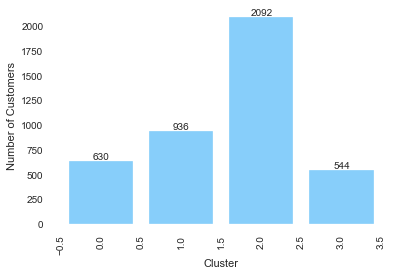

In [350]:
count = df_RFM_no.groupby(df_RFM_no.Hierar_Cluster).size()
visualization_countplot(count)

In [351]:
hierar_agg_no = Lib.create_df_agg(df_RFM_no, 'Hierar_Cluster')
hierar_agg_no

Hierar_Cluster  RecencyMean  FrequencyMean  MonetaryMean  RMean  FMean  \
0               0         26.0           11.0        4697.0    4.0    5.0   
1               1        162.0            2.0         708.0    2.0    3.0   
2               2         41.0            3.0         972.0    4.0    3.0   
3               3        290.0            1.0         440.0    1.0    2.0   

   MMean  Count  Percent  
0    5.0    630    14.99  
1    2.0    936    22.28  
2    3.0   2092    49.79  
3    2.0    544    12.95

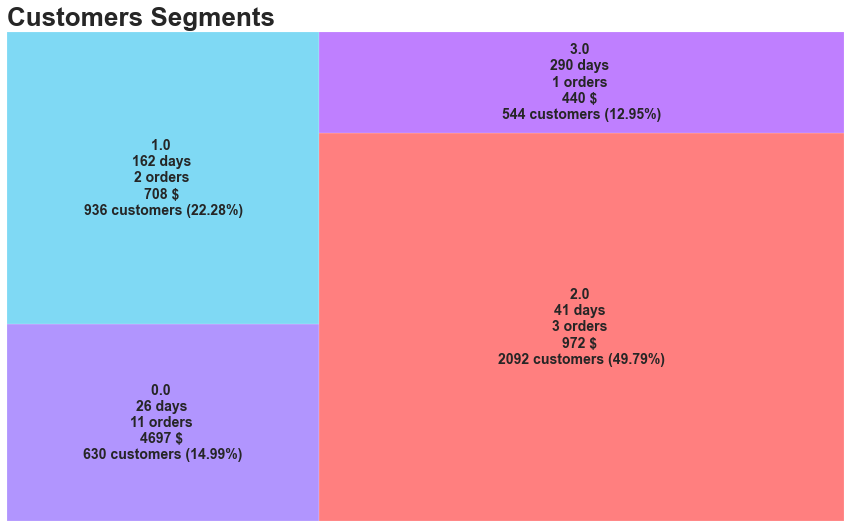

In [353]:
treemap_customer_segmentation(hierar_agg_no.iloc[:,[0,1,2,3,7,8]],14)

In [354]:
# Visualization - 2D Scatter
fig = px.scatter(hierar_agg_no, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Hierar_Cluster",
           hover_name="Hierar_Cluster", size_max=80)
fig.show()

In [355]:
# Visualization - 3D scatter
df_RFM_no_log = df_RFM_no.copy()
df_RFM_no_log['Recency'] = np.log(df_RFM_no_log['Recency'])
df_RFM_no_log['Frequency'] = np.log(df_RFM_no_log['Frequency'])
df_RFM_no_log['Monetary'] = np.log(df_RFM_no_log['Monetary'])

fig = px.scatter_3d(df_RFM_no_log, x='Recency', y='Frequency', z='Monetary',
                    color = 'Hierar_Cluster', opacity=0.5)
fig.update_traces(marker=dict(size=5),selector=dict(mode='markers'))
fig.show()

- Trên tập dữ liệu Scaled Non-Outliers, KMeans và Hierarchical cho kết quả phân cụm tốt tương đương nhau. 
- Tuy nhiên, silhouette score của KMeans là ~0.473, nhỉnh hơn một chút so với Hierarchical ~0.470.
- Và trên 3D Scatter plot, ta có thể quan sát thấy Hierarchical vẫn còn một vài điểm dữ liệu lẫn lộn giữa các nhóm, trong khi KMeans thì gần như hoàn toàn tách biệt

### 3.11 DBSCAN

In [361]:
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(df_RFM_no_scaled)
distances, indices = neighbors_fit.kneighbors(df_RFM_no_scaled)
distances = np.sort(distances, axis=0)

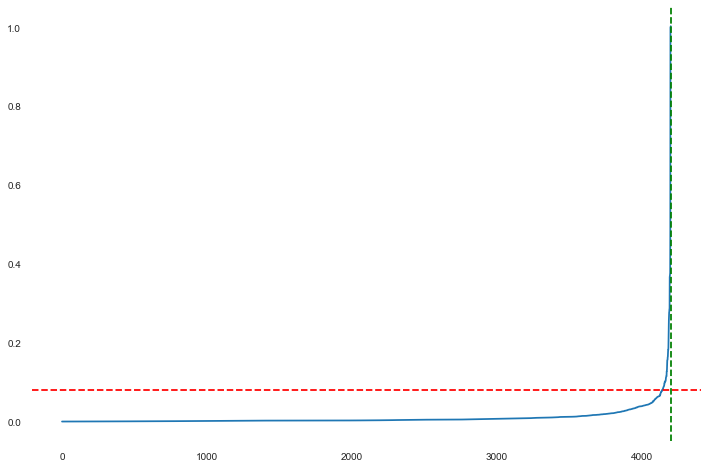

In [367]:
# Theo phương pháp khuỷu tay để tìm esp (Epsilon (ε))
plt.figure(figsize=(12,8))
distances_draw = distances[:,1]
plt.plot(distances_draw)
plt.axhline(y=0.08, color='r', linestyle='--')
plt.axvline(x=4200, color='g', linestyle='--')

In [387]:
dbscan_model = DBSCAN(eps=0.08, min_samples=90)
dbscan_model.fit(df_RFM_no_scaled)

DBSCAN(eps=0.08, min_samples=90)

In [391]:
# unique cluster
np.unique(dbscan_model.labels_)

array([-1,  0,  1,  2,  3])

In [389]:
df_RFM_no['DBSCAN_Cluster'] = dbscan_model.fit_predict(df_RFM_no_scaled)
df_RFM_no.head()

Recency  Frequency  Monetary  R  F  M  KMeans_Cluster  \
CustomerID                                                          
14680.0          26         16  28754.11  4  5  5               3   
13081.0          12         11  28337.38  5  5  5               3   
17857.0          18         23  26879.04  5  5  5               3   
16333.0         124         22  26626.80  2  5  5               3   
12753.0          23          6  21429.39  4  4  5               3   

            GMM_Cluster  Hierar_Cluster  DBSCAN_Cluster  
CustomerID                                               
14680.0               1               0              -1  
13081.0               1               0              -1  
17857.0               1               0              -1  
16333.0               1               0              -1  
12753.0               1               0              -1

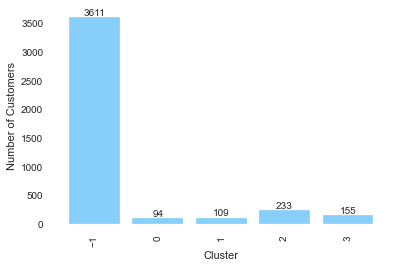

In [390]:
count = df_RFM_no.groupby(df_RFM_no.DBSCAN_Cluster).size()
visualization_countplot(count)

Kết quả phân cụm không đồng đều (imbalanced) => Thuật toán DBSCAN không phù hợp

### 3.12 Mini-Batch K-Means

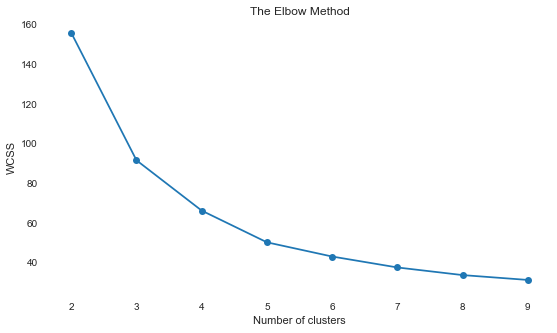

In [393]:
# Select k using Elbow method
plt.figure(figsize=(9,5))
wcss = []
for k in range(2, 10):
    mbk = MiniBatchKMeans(n_clusters = k, random_state=42)
    mbk.fit(df_RFM_no_scaled[['Recency','Frequency','Monetary']])
    wcss.append(mbk.inertia_)
plt.plot(range(2, 10), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [394]:
mbk = MiniBatchKMeans(n_clusters=4)
mbk.fit(df_RFM_no_scaled)

MiniBatchKMeans(n_clusters=4)

In [398]:
sil_mbk = metrics.silhouette_score(df_RFM_no_scaled[['Recency','Frequency','Monetary']],
                                      mbk.predict(df_RFM_no_scaled), metric='euclidean')
sil_mbk

0.10581691806898909

In [396]:
df_RFM_no['mbk_Cluster'] = mbk.predict(df_RFM_no_scaled)
df_RFM_no.head()

Recency  Frequency  Monetary  R  F  M  KMeans_Cluster  \
CustomerID                                                          
14680.0          26         16  28754.11  4  5  5               3   
13081.0          12         11  28337.38  5  5  5               3   
17857.0          18         23  26879.04  5  5  5               3   
16333.0         124         22  26626.80  2  5  5               3   
12753.0          23          6  21429.39  4  4  5               3   

            GMM_Cluster  Hierar_Cluster  DBSCAN_Cluster  mbk_Cluster  
CustomerID                                                            
14680.0               1               0              -1            1  
13081.0               1               0              -1            1  
17857.0               1               0              -1            1  
16333.0               1               0              -1            1  
12753.0               1               0              -1            1

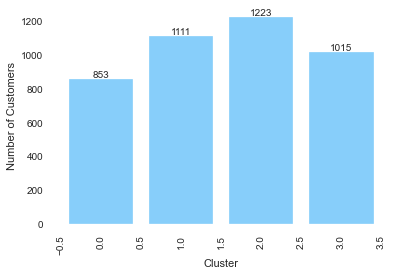

In [397]:
count = df_RFM_no.groupby(df_RFM_no.mbk_Cluster).size()
visualization_countplot(count)

In [399]:
mbk_agg_no = Lib.create_df_agg(df_RFM_no, 'mbk_Cluster')
mbk_agg_no

mbk_Cluster  RecencyMean  FrequencyMean  MonetaryMean  RMean  FMean  MMean  \
0            0         97.0            1.0         666.0    3.0    1.0    3.0   
1            1         27.0            8.0        3553.0    4.0    5.0    5.0   
2            2         69.0            3.0         920.0    3.0    3.0    3.0   
3            3        212.0            1.0         250.0    1.0    2.0    1.0   

   Count  Percent  
0    853    20.30  
1   1111    26.44  
2   1223    29.11  
3   1015    24.16

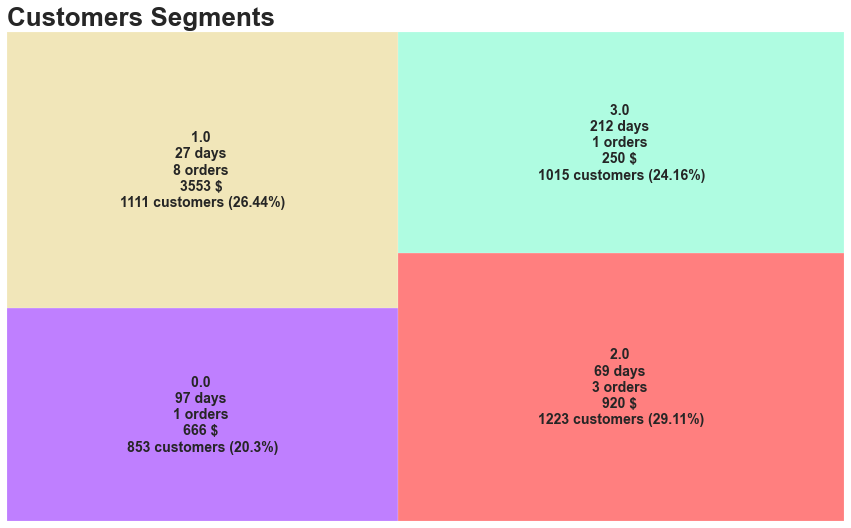

In [400]:
treemap_customer_segmentation(mbk_agg_no.iloc[:,[0,1,2,3,7,8]],font_size)

In [401]:
# Visualization - 2D Scatter
fig = px.scatter(mbk_agg_no, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="mbk_Cluster",
           hover_name="mbk_Cluster", size_max=80)
fig.show()

In [402]:
# Visualization - 3D scatter
df_RFM_no_log = df_RFM_no.copy()
df_RFM_no_log['Recency'] = np.log(df_RFM_no_log['Recency'])
df_RFM_no_log['Frequency'] = np.log(df_RFM_no_log['Frequency'])
df_RFM_no_log['Monetary'] = np.log(df_RFM_no_log['Monetary'])

fig = px.scatter_3d(df_RFM_no_log, x='Recency', y='Frequency', z='Monetary',
                    color = 'mbk_Cluster', opacity=0.5)
fig.update_traces(marker=dict(size=5),selector=dict(mode='markers'))
fig.show()

- Thuật toán Mini-batch KMeans phân cụm balanced hơn KMeans và Hierarchical, tuy nhiên silhouette score rất thấp chỉ 0.1058 so với KMeans và Hierarchical (~0.47). 
- Và ta có thể quan sát thấy trên 3D scatter, các nhóm dữ liệu của Mini-batch KMeans không hoàn toàn tách biệt như KMeans

- => Trong các mô hình vừa xây dựng, mô hình thuật toán KMeans trên Scaled Non-Outliers Data là mô hình mang lại kết qủa tốt nhất.
- Tuy nhiên, ở bước tiếp theo ta xem xét tới những khách hàng upper outliers mà ta đã loại bỏ.

In [405]:
df_outlier.head()

Recency  Frequency   Monetary  R  F  M
CustomerID                                        
14646.0           2         74  280206.02  5  5  5
18102.0          12         60  259657.30  5  5  5
17450.0           3         46  194390.79  5  5  5
16446.0          89          2  168472.50  2  2  5
14911.0           0        201  143711.17  5  5  5

In [406]:
df_outlier.shape

(137, 6)

In [407]:
df_outlier.describe()

Recency   Frequency       Monetary           R           F  \
count  137.000000  137.000000     137.000000  137.000000  137.000000   
mean   330.197080   21.416058   21847.655839    2.686131    3.087591   
std    298.465705   33.327396   44972.669487    1.904916    1.763496   
min      0.000000    1.000000      15.000000    1.000000    1.000000   
25%     11.000000    1.000000     208.970000    1.000000    1.000000   
50%    454.000000    1.000000     590.000000    1.000000    2.000000   
75%    666.000000   33.000000   20374.280000    5.000000    5.000000   
max    697.000000  210.000000  280206.020000    5.000000    5.000000   

                M  
count  137.000000  
mean     3.153285  
std      1.806404  
min      1.000000  
25%      1.000000  
50%      3.000000  
75%      5.000000  
max      5.000000

Ta sẽ sử dụng Manual RFM để chia nhóm các khách hàng này:
- Nhóm Platinum gồm khách hàng High Monetary hoặc khách hàng High Frequency và Monetary > Monetary.mean()
- Nhóm Regulars gồm khách hàng High Frequency và Monetary <= Monetary.mean()
- Nhóm Ghost gồm khách hnafg High Recency và không thuộc 2 nhóm trên

In [408]:
Monetary_mean = df_RFM.Monetary.mean()
Monetary_mean

2048.2159230237385

In [411]:
platinum, regulars, ghost = Lib.elite_regular_ghost_group(df_RFM, df_outlier, max_m, max_f, max_r, Monetary_mean)
platinum.shape, regulars.shape, ghost.shape

((62, 8), (1, 8), (74, 8))

In [417]:
# Visualization - 3D scatter plot
df_RFM_no_log = df_RFM_no.copy()
df_RFM_no_log['Recency'] = np.log(df_RFM_no_log['Recency'])
df_RFM_no_log['Frequency'] = np.log(df_RFM_no_log['Frequency'])
df_RFM_no_log['Monetary'] = np.log(df_RFM_no_log['Monetary'])

fig = px.scatter_3d(df_RFM_no_log, x='Recency', y='Frequency', z='Monetary',
                    color = 'KMeans_Cluster', opacity=0.5)
fig.update_traces(marker=dict(size=5),selector=dict(mode='markers'))

#Add Platinum, Regulars, Ghost
fig.add_trace(go.Scatter3d(x=np.log(ghost['Recency']), y=np.log(ghost['Frequency']), z=np.log(ghost['Monetary']), 
                      mode='markers',marker=dict(color='green', symbol='cross'), textposition='top left', showlegend=False))
fig.add_trace(go.Scatter3d(x=np.log(platinum['Recency']), y=np.log(platinum['Frequency']), z=np.log(platinum['Monetary']), 
                      mode='markers',marker=dict(color='red', symbol='cross'), textposition='top left', showlegend=False))
fig.add_trace(go.Scatter3d(x=np.log(regulars['Recency']), y=np.log(regulars['Frequency']), z=np.log(regulars['Monetary']), 
                      mode='markers',marker=dict(color='orange', symbol='cross'), textposition='top left', showlegend=False))
fig.show()

Dựa trên 3D Scatter plot, ta sẽ gom nhóm Ghost vào chung với nhóm 1, nhóm Regulars chung với nhóm 3, nhóm Platinum là nhóm khách hàng quan trọng nên ta sẽ để một nhóm riêng

In [421]:
df_RFM_no.head()

Recency  Frequency  Monetary  R  F  M  KMeans_Cluster  \
CustomerID                                                          
14680.0          26         16  28754.11  4  5  5               3   
13081.0          12         11  28337.38  5  5  5               3   
17857.0          18         23  26879.04  5  5  5               3   
16333.0         124         22  26626.80  2  5  5               3   
12753.0          23          6  21429.39  4  4  5               3   

            GMM_Cluster  Hierar_Cluster  DBSCAN_Cluster  mbk_Cluster  
CustomerID                                                            
14680.0               1               0              -1            1  
13081.0               1               0              -1            1  
17857.0               1               0              -1            1  
16333.0               1               0              -1            1  
12753.0               1               0              -1            1

In [432]:
regulars['KMeans_Cluster'] = 3
ghost['KMeans_Cluster'] = 1
platinum['KMeans_Cluster'] = 4
final_df = pd.concat([df_RFM_no, regulars, ghost, platinum])[['Recency', 'Frequency', 'Monetary', 'R', 'F', 'M', 'KMeans_Cluster']]
final_df.head()

Recency  Frequency  Monetary  R  F  M  KMeans_Cluster
CustomerID                                                       
14680.0          26         16  28754.11  4  5  5               3
13081.0          12         11  28337.38  5  5  5               3
17857.0          18         23  26879.04  5  5  5               3
16333.0         124         22  26626.80  2  5  5               3
12753.0          23          6  21429.39  4  4  5               3

In [436]:
final_agg = Lib.create_df_agg(final_df, 'KMeans_Cluster')

dict_seg = {0:'Deluxe', 1:'Ghost', 2:'Member', 3:'Gold', 4:'Platinum'}
final_agg['Cluster_name'] = final_agg['KMeans_Cluster'].apply(lambda x: dict_seg[x])
final_agg.iloc[:,[0,9,1,2,3,4,5,6,7,8]]

KMeans_Cluster Cluster_name  RecencyMean  FrequencyMean  MonetaryMean  \
0               0       Deluxe         37.0            3.0        1190.0   
1               1        Ghost        310.0            1.0         429.0   
2               2       Member        147.0            2.0         729.0   
3               3         Gold         24.0           13.0        5651.0   
4               4     Platinum         18.0           45.0       47841.0   

   RMean  FMean  MMean  Count  Percent  
0    4.0    3.0    3.0   2206    50.84  
1    1.0    2.0    2.0    737    16.99  
2    2.0    3.0    2.0    926    21.34  
3    4.0    5.0    5.0    408     9.40  
4    5.0    5.0    5.0     62     1.43

Cluster description:
- Cluster 4 - PLATINUM    : Huge spending or Frequent purchase and High spending
- Cluster 3 - GOLD        : High spending, frequent purchase and recently buying
- Cluster 0 - DELUXE      : Medium-high spending, , quite frequent purchase and recently buying
- Cluster 2 - MEMBER      : Low spending, infrequent purchase and have not purchased for a long time
- Cluster 1 - GHOST       : Only few times purchase, low spending and have not purchased for a long time

In [440]:
# Add Cluster_name to final_df
final_df['Cluster_name'] = final_df['KMeans_Cluster'].apply(lambda x: dict_seg[x])
final_df.head()

Recency  Frequency  Monetary  R  F  M  KMeans_Cluster Cluster_name
CustomerID                                                                    
14680.0          26         16  28754.11  4  5  5               3         Gold
13081.0          12         11  28337.38  5  5  5               3         Gold
17857.0          18         23  26879.04  5  5  5               3         Gold
16333.0         124         22  26626.80  2  5  5               3         Gold
12753.0          23          6  21429.39  4  4  5               3         Gold

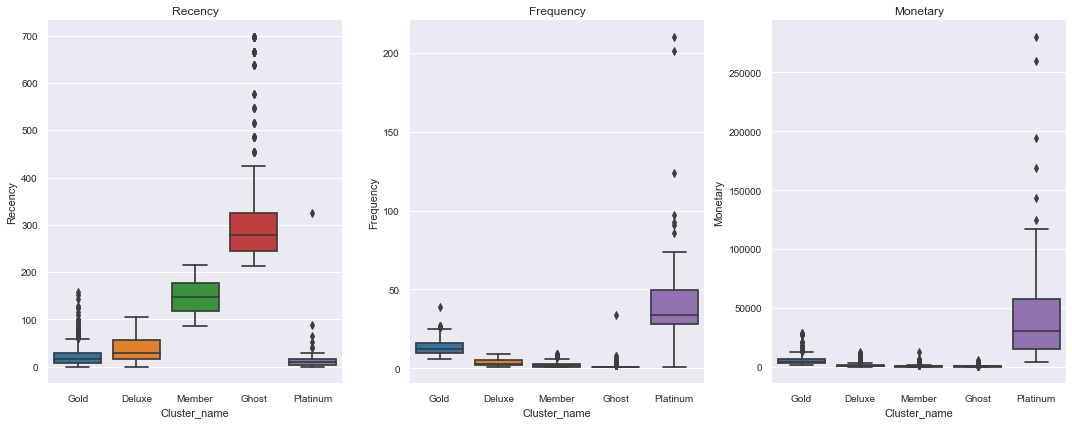

In [441]:
# Visualize để thấy điểm đặc trưng của các nhóm
plt.figure(figsize=(15, 6))
sns.set_style('darkgrid')
plt.subplot(1,3,1)
sns.boxplot(x='Cluster_name', y='Recency', data=final_df)
plt.title('Recency')
plt.subplot(1,3,2)
sns.boxplot(x='Cluster_name', y='Frequency', data=final_df)
plt.title('Frequency')
plt.subplot(1,3,3)
sns.boxplot(x='Cluster_name', y='Monetary', data=final_df)
plt.title('Monetary')
plt.tight_layout()
plt.show()

## Conclusion
- Manual RFM chia khách hàng thành 8 nhóm khách hàng khá cân bằng, tuy nhiên các nhóm dữ liệu không hoàn toàn tách biệt mà vẫn còn lẫn lộn với nhau. Trong khi đó, phương pháp KMeans kết hợp Manual RFM cho kết quả là 5 nhóm khách hàng hoàn toàn tách biệt.
- Trên thực tế, việc phân chia quá nhiều nhóm khách hàng có thể dẫn tới việc khó khăn trong xây dựng chiến lược, tốn nhiều chi phí và nguồn lực hơn để quản lý khách hàng. Do đó, số nhóm khách hàng bằng 5 sẽ tối ưu hơn 8 nhóm.
- => Kết luận: Chọn phương án KMeans kết hợp Manual RFM (final_df)

# Step 6: Deployment & Feedback/Act 